# I’m Something of a Painter Myself - Use GANs to create art - will you be the next Monet?

### Jakub Kucera (kucerj56)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

/Users/jakubkucera/Documents/NI-MVI/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jakubkucera/Documents/NI-MVI/.venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jakubkucera/Documents/NI-MVI/.venv/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <06D2C3BD-26E5-3AB9-A866-63839BE393A7> /Users/jakubkucera/Documents/NI-MVI/.venv/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <44B645FB-F027-3EE5-86D7-DBF8E2FC6264> /Users/jakubkucera/Documents/NI-MVI/.venv/lib/python3.10/site-packages/torc

In [2]:
# if torch.backends.mps.is_available():
#     device = torch.device("mps") # Apple ARM GPU
# elif torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')

In [3]:
device = torch.device('cpu')

In [4]:
MONET_DATA_PATH = "./data-monet/monet/"
ORIG_DATA_PATH = "./data-monet/photo/"
BATCH_SIZE = 128
IMG_SIZE = 256
# IMG_VALUE_COUNT = IMG_SIZE * IMG_SIZE
IMG_VALUE_COUNT = IMG_SIZE * IMG_SIZE * 3
EPOCH_COUNT = 20

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

monet_dataset = ImageFolder(root=MONET_DATA_PATH, transform=transform)

orig_dataset = ImageFolder(root=ORIG_DATA_PATH, transform=transform)

In [6]:
monet_dataloader = torch.utils.data.DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
orig_dataloader = torch.utils.data.DataLoader(orig_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [7]:
# arr = np.swapaxes(next(iter(monet_dataloader))[0][111].numpy(), 2, 1)
# arr = next(iter(monet_dataloader))[0][111].numpy()[2]
arr = next(iter(monet_dataloader))[0][111].numpy().transpose((1, 2, 0))

In [8]:
for image, _ in orig_dataloader:
    print(np.shape(image))
    break

torch.Size([128, 3, 256, 256])


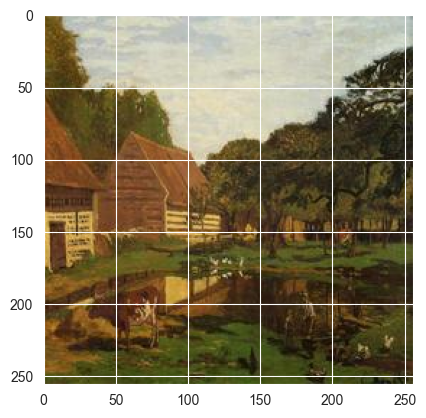

In [9]:
plt.imshow(arr, cmap='Greys_r')

In [10]:
class Generator(nn.Module):
    # TODO completely rewrite
    def __init__(self, gen_input_dim, gen_output_dim):
        super(Generator, self).__init__()
        # self.fc1 = nn.Linear(gen_input_dim, 256)
        # self.fc2 = nn.Linear(256, 512)
        # self.fc1 = nn.Linear(gen_input_dim, gen_output_dim)
        # self.fc1 = nn.Linear(gen_input_dim, 512)
        # self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,3), stride=(1,1))
        # self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 256 * 3, 32*32*3)
        # self.fc1 = nn.Linear(gen_input_dim, 32*32*3)
        self.fc2 = nn.Linear(32*32*3, gen_output_dim)
        # self.fc2 = nn.Linear(512, 1024)
        # self.fc3 = nn.Linear(1024, gen_output_dim)

    # forward method
    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = x.flatten(x, 1)
        x = x.view(128, -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        return torch.tanh(self.fc2(x))
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # return torch.tanh(self.fc3(x))
        # return torch.tanh(self.fc1(x))

In [11]:
class Discriminator(nn.Module):
    # TODO use Convolutions and just completely rewrite
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)

    # forward method
    def forward(self, x, labels):
        # x = x.view(-1, 784) # TODO change
        x = x.view(128, -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [12]:
# class Convertor(nn.Module):
#     # TODO completely rewrite
#     def __init__(self, gen_input_dim, gen_output_dim):
#         super(Convertor, self).__init__()
#         # self.fc1 = nn.Linear(gen_input_dim, 256)
#         # self.fc2 = nn.Linear(256, 512)
#         self.fc1 = nn.Linear(gen_input_dim, 512)
#         self.fc2 = nn.Linear(512, 1024)
#         self.fc3 = nn.Linear(1024, gen_output_dim)
#
#     # forward method
#     def forward(self, x):
#         # x = F.leaky_relu(self.fc1(x), 0.2)
#         x = F.leaky_relu(self.fc1(x), 0.2)
#         x = F.leaky_relu(self.fc2(x), 0.2)
#         return torch.tanh(self.fc3(x))

In [13]:
# # TODO sort out dimensions
generator_r2m = Generator(gen_input_dim = IMG_VALUE_COUNT, gen_output_dim = IMG_VALUE_COUNT).to(device)
generator_m2r = Generator(gen_input_dim = IMG_VALUE_COUNT, gen_output_dim = IMG_VALUE_COUNT).to(device)
discriminator_r = Discriminator(IMG_VALUE_COUNT).to(device)
discriminator_m = Discriminator(IMG_VALUE_COUNT).to(device)

In [14]:
criterion_1 = nn.BCELoss()
criterion_2 = nn.BCELoss()

optimizer_gen_a = optim.Adam(generator_r2m.parameters(), lr = 0.0001)
optimizer_gen_b = optim.Adam(generator_m2r.parameters(), lr = 0.0001)
optimizer_disc_r = optim.Adam(discriminator_r.parameters(), lr = 0.0001)
optimizer_disc_m = optim.Adam(discriminator_m.parameters(), lr = 0.0001)

In [15]:
def label_real(b_size = BATCH_SIZE):
    data = torch.ones(b_size, 1)
    return data.to(device)

def label_fake(b_size = BATCH_SIZE):
    data = torch.zeros(b_size, 1)
    return data.to(device)

In [16]:
# def train_real_2_fake_2_real(data_real,
#                         labels,
#                         data_fake,
#                         generator = generator,
#                         discriminator = discriminator,
#                         optimizer = optimizer_disc,
#                         batch_size = BATCH_SIZE
#                         ):
#
#     optimizer.zero_grad()
#     discriminator.train()
#
#     ones = label_real(data_real.shape[0])
#     zeros = label_fake(data_real.shape[0])
#
#     output_real = discriminator(data_real, labels)
#     loss_real = criterion(output_real, ones)
#
#     output_fake = discriminator(data_fake, torch.randint(0, 10, (image.shape[0], )).to(device))
#     loss_fake = criterion(output_fake, zeros)
#
#     loss_real.backward()
#     loss_fake.backward()
#     optimizer.step()
#
#     return loss_real + loss_fake

In [17]:
def train_discriminator(data_real,
                        labels,
                        data_fake,
                        generator,
                        discriminator,
                        optimizer,
                        criterion,
                        batch_size = BATCH_SIZE
                        ):

    optimizer.zero_grad()
    discriminator.train()

    ones = label_real(data_real.shape[0])
    zeros = label_fake(data_real.shape[0])

    print(data_real.shape)
    print(labels.shape)
    output_real = discriminator(data_real, labels)
    loss_real = criterion(output_real, ones)

    output_fake = discriminator(data_fake, torch.randint(0, 10, (image.shape[0], )).to(device))
    loss_fake = criterion(output_fake, zeros)

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    return loss_real + loss_fake

In [18]:
def train_generator(data_fake,
                    generator,
                    discriminator,
                    optimizer,
                    criterion,
                    labels = torch.randint(0, 10, (BATCH_SIZE, )).to(device),
                    batch_size = BATCH_SIZE
                    ):

    optimizer.zero_grad()
    generator.train()

    ones = label_real(data_fake.shape[0])

    output = discriminator(data_fake, labels)
    loss = criterion(output, ones)

    loss.backward()
    optimizer.step()

    return loss

In [ ]:
from datetime import datetime

start = datetime.now()

loss_gen = []
loss_disc = []

for epoch in range(1, EPOCH_COUNT+1):

    print(f"Epoch #{epoch}")

    loss_g = 0.0
    loss_d = 0.0

    for images, labels in orig_dataloader:
        images, labels = images.to(device), labels.to(device)
        print(images.shape)

        data_real = images
        data_fake = generator_r2m(images).detach()
        # data_fake = generator(create_noise(image.shape[0], noise_dim)).detach()


        data_real_fake_real = generator_m2r(data_fake)

        # train the discriminator network
        loss_d += train_discriminator(data_real=data_real, labels=labels, data_fake=data_fake, generator= generator_r2m,
                                      discriminator=discriminator_r , optimizer=optimizer_disc_r, criterion=criterion_1)
        # data_fake = generator(create_noise(image.shape[0], noise_dim))
        # TODO why is generate here 2 times?
        data_fake = generator_r2m(images)

        # train the generator network
        loss_g += train_generator(data_fake=data_fake, generator=generator_r2m, discriminator=discriminator_r , optimizer=optimizer_disc_r, criterion=criterion_1)

    loss_gen.append(loss_g.item())
    loss_disc.append(loss_d.item())

end = datetime.now()
print(f"Training took {end-start}")

In [19]:
from datetime import datetime

start = datetime.now()

loss_gen = []
loss_disc = []

for epoch in range(1, EPOCH_COUNT+1):

    print(f"Epoch #{epoch}")

    loss_g = 0.0
    loss_d = 0.0

    for images, labels in orig_dataloader:
        images, labels = images.to(device), labels.to(device)
        print(images.shape)

        # run the discriminator for k number of steps
        for step in range(1):
            # single_image = image[0]
            # print(single_image.shape)
            #make it black and white
            # single_image_mono = single_image.mean(axis = 0)
            # print(single_image_mono.shape)
            data_fake = generator_r2m(images).detach()
            # data_fake = generator(create_noise(image.shape[0], noise_dim)).detach()
            data_real = images

            # train the discriminator network
            loss_d += train_discriminator(data_real=data_real, labels=labels, data_fake=data_fake, generator= generator_r2m, discriminator=discriminator_r , optimizer=optimizer_disc_r, criterion=criterion_1)
        # data_fake = generator(create_noise(image.shape[0], noise_dim))
        # TODO why is generate here 2 times?
        data_fake = generator_r2m(images)

        # train the generator network
        loss_g += train_generator(data_fake=data_fake, generator=generator_r2m, discriminator=discriminator_r , optimizer=optimizer_disc_r, criterion=criterion_1)

    loss_gen.append(loss_g.item())
    loss_disc.append(loss_d.item())

end = datetime.now()
print(f"Training took {end-start}")

Epoch #1
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])
torch.Size([128, 3, 256, 256])
torch.Size([128])
torch.Size([128, 3, 256, 256])


KeyboardInterrupt: 

In [34]:
images = next(iter(orig_dataloader))[0]
images.to(device)
images_fake = generator_r2m(images).detach()
for i in range(0, 15):
    orig_img = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(arr)
    plt.imshow(images_fake[i].view(256, 256, 3))


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [20]:
arr = next(iter(orig_dataloader))[0][111].numpy().transpose((1, 2, 0))

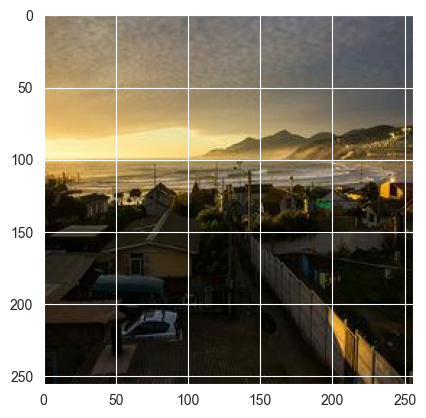

In [21]:
plt.imshow(arr, cmap='Greys_r')

In [24]:
images = next(iter(orig_dataloader))[0]
images.to(device)

/Users/jakubkucera/Documents/NI-MVI/.venv/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([[[[0.7098, 0.9176, 0.8588,  ..., 0.5765, 0.5804, 0.5804],
          [0.6941, 0.9529, 0.8549,  ..., 0.5686, 0.5686, 0.5686],
          [0.6588, 0.8039, 0.8784,  ..., 0.5608, 0.5608, 0.5569],
          ...,
          [0.4431, 0.3529, 0.4627,  ..., 0.1961, 0.2000, 0.1804],
          [0.4392, 0.4510, 0.4510,  ..., 0.1804, 0.1882, 0.1647],
          [0.3882, 0.4706, 0.3961,  ..., 0.1725, 0.1882, 0.1686]],

         [[0.5176, 0.7451, 0.7059,  ..., 0.8706, 0.8745, 0.8745],
          [0.5059, 0.7765, 0.7020,  ..., 0.8627, 0.8627, 0.8627],
          [0.4902, 0.6392, 0.7176,  ..., 0.8549, 0.8549, 0.8510],
          ...,
          [0.3490, 0.2667, 0.3765,  ..., 0.3412, 0.3333, 0.3176],
          [0.3373, 0.3569, 0.3647,  ..., 0.3176, 0.3176, 0.2941],
          [0.2863, 0.3765, 0.3020,  ..., 0.3098, 0.3176, 0.2980]],

         [[0.2980, 0.5059, 0.4431,  ..., 0.8941, 0.8980, 0.8980],
          [0.3137, 0.5451, 0.4078,  ..., 0.8863, 0.8863, 0.8863],
          [0.3255, 0.4118, 0.3725,  ..., 0

In [25]:
data_fake = generator_r2m(images).detach()

RuntimeError: Placeholder storage has not been allocated on MPS device!

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

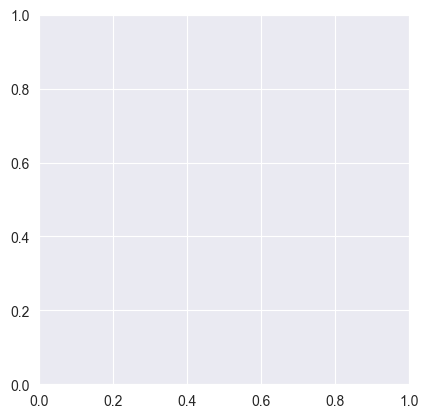

In [26]:
# data_fake[1].
plt.imshow(data_fake[120].view(256, 256, 3))

In [29]:
STORAGE_DIR = "models/"
PATH = STORAGE_DIR + "01/"
torch.save(generator_r2m, PATH + "generator_r2m.pt")
torch.save(generator_m2r, PATH + "generator_m2r.pt")
torch.save(discriminator_r, PATH + "discriminator_r.pt")
torch.save(discriminator_m, PATH + "discriminator_m.pt")


In [30]:
generator_r2m = torch.load(PATH + "generator_r2m.pt")
generator_m2r = torch.load(PATH + "generator_m2r.pt")
discriminator_r = torch.load(PATH + "discriminator_r.pt")
discriminator_m = torch.load(PATH + "discriminator_m.pt")